<a href="https://colab.research.google.com/github/joamho-luiz/Trabalho-FMC/blob/main/Gr%C3%A1fico_Proje%C3%A7%C3%A3o_Temperatura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Esse código gera um gráfico com a projeção de anomalia de temperatura para dois cenários futuros.

# Instalação e Importação e Funções

In [ ]:
!pip install --upgrade  xarray zarr gcsfs cftime nc-time-axis 
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr
import zarr
import gcsfs
import numpy as np
from matplotlib.axes import Axes

In [ ]:
def temperatura(mod):
  pd_tas_timeseries=mod.tas.to_pandas() # Transformando xarray para pandas
  tasm=pd_tas_timeseries.loc['1951-01':'1980-12'].mean() #Calculando a média de 1950 até 1980 como no GISS_TEMP
  return tasm # Temperatura média do modelo

def anomalias(mod):
  pd_tas_timeseries=mod.tas.to_pandas()
  pd_atas_timeseries=pd_tas_timeseries- temperatura(mod)
  ano=pd_atas_timeseries.resample("1y").median()
  yys=ano.reset_index()
  ys=yys[0] #separa a TAS
  tempo=yys['time'] #separa a data
  xx=tempo.to_list() #coloca em uma lista
  xs=np.int16([date.strftime("%Y") for date in xx]).tolist() #pegue apenas o ano e ignore o dia e mês
  plt.plot(xs, ys, label='NUIST')

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

def busca(y):
  modelo_tas = modelos.query(y)
  return modelo_tas

def media12(par):
  gcs = gcsfs.GCSFileSystem(token='anon')
  modelo=busca(par)
  zstore = modelo.zstore.values[0]
  mapper = gcs.get_mapper(zstore)
  ds = xr.open_zarr(mapper, consolidated=True)
  df=ds.tas.to_dataframe()
  G= global_mean(ds) - 273
  #plt.plot(G.time, G.tas)              ##
  Med12= G.rolling(time=12).mean()
  #plt.plot(Med12.time, Med12.tas)      ##
  return Med12

# Carregar dados utilizados

## _Execute apenas o modelo que for utilizar_

\> > Você só precisa definir os modelos aqui:

In [ ]:
# EC:
institution_id = "EC-Earth-Consortium"      
source_id = "EC-Earth3"
experiment_id = "historical"
table_id = "Amon"
variable_id = "tas"

In [ ]:
# E3:
institution_id = "E3SM-Project"
source_id = "E3SM-1-1"
experiment_id = "historical"
table_id = "Amon"
variable_id = "tas"

In [ ]:
# CN:
institution_id = "CNRM-CERFACS"
source_id = "CNRM-CM6-1"
experiment_id = "historical"
table_id = "Amon"
variable_id = "tas"

## _Executude os demais códigos_

In [ ]:
# Comente o que não deve ser definido
parametro = ""
parametro += f" & institution_id == '{institution_id}'" if parametro != "" else f"institution_id == '{institution_id}'"  
parametro += f" & source_id == '{source_id}'" if parametro != "" else f"source_id == '{source_id}'"  
parametro += f" & experiment_id == '{experiment_id}'" if parametro != "" else f"experiment_id == '{experiment_id}'"  
parametro += f" & table_id == '{table_id}'" if parametro != "" else f"table_id == '{table_id}'"  
parametro += f" & variable_id == '{variable_id}'" if parametro != "" else f"variable_id == '{variable_id}'"  
parametros = parametro

In [ ]:
lista_de_modelos = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
modelos=lista_de_modelos.query("table_id=='Amon' | table_id=='fx'" )
%load_ext google.colab.data_table

modelo_tas = modelos.query(parametros )
modelo_tas

# Geração de Imagem

In [ ]:
# isso só precisa ser criado uma vez
gcs = gcsfs.GCSFileSystem(token='anon')

# obter o caminho para um armazenamento zarr específico (o primeiro do dataframe acima)
zstore = modelo_tas.zstore.values[0]
zstore
# criar uma interface de estilo de mapeamento mutável para a loja
mapper = gcs.get_mapper(zstore)

# abra usando xarray e zarr
ds = xr.open_zarr(mapper, consolidated=True)
df=ds.tas.to_dataframe()

In [ ]:
MODELO_A_hist=media12(f"experiment_id == 'historical' & source_id=='{source_id}' & variable_id == 'tas'")
MODELO_A_126=media12(f"experiment_id == 'ssp126' & source_id=='{source_id}' & variable_id == 'tas'")
#MODELO_A_245=media12(f"experiment_id == 'ssp245' & source_id=='{source_id}' & variable_id == 'tas'")        #Nem todo modelo tem esse experimento
MODELO_A_585=media12(f"experiment_id == 'ssp585' & source_id=='{source_id}' & variable_id == 'tas'")

MODELO_A_anomalia= temperatura(MODELO_A_hist)
MODELO_A_anomalia

13.137169084276431

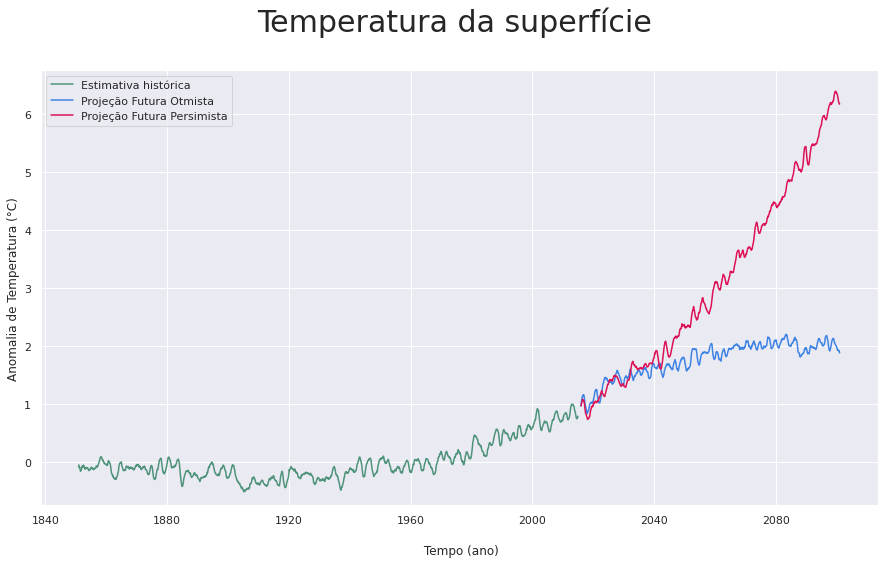

In [ ]:
sns.set_theme()
plt.figure(figsize=(15, 8))

# Curvas
plt.plot(MODELO_A_hist.time, MODELO_A_hist.tas-MODELO_A_anomalia, label='Estimativa histórica', c='#4e937a')
plt.plot(MODELO_A_126.time, MODELO_A_126.tas-MODELO_A_anomalia, label='Projeção Futura Otmista',c='#3f84e5')
# plt.plot(MODELO_A_245.time, MODELO_A_245.tas-MODELO_A_anomalia, label='Projeção Futura Viável',c='#544e61')
plt.plot(MODELO_A_585.time, MODELO_A_585.tas-MODELO_A_anomalia, label='Projeção Futura Persimista', c='#dd1155')
# plt.axhline(0, color='#544e61', label='Média da temperatura \n entre 1950-1980')

# Legendas
plt.title('Temperatura da superfície \n', fontsize=30)
plt.xlabel('\n Tempo (ano)')
plt.ylabel('Anomalia de Temperatura (°C)')

# Posições e Recortes
plt.legend(loc="upper left")
plt.ylim(-0.75, 6.75)
# plt.xlim(-55000, 38200)

# Salvar Imagem
plt.savefig(f'anomalia_temperatura {institution_id}.png', dpi=500, bbox_inches='tight')